In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

import scipy.stats
import scipy.linalg as la
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Flight data from the JFK airport from November 2019 to December 2020.\
Target is to predict the runway time (TAXI_OUT) to save the cost of flight

In [7]:
df = pd.read_csv('M1_final.csv')
# quick preview
df.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM',
       'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_DEP_M',
       'DEP_TIME_M', 'CRS_ARR_M', 'Temperature', 'Dew Point', 'Humidity',
       'Wind', 'Wind Speed', 'Wind Gust', 'Pressure', 'Condition', 'sch_dep',
       'sch_arr', 'TAXI_OUT'],
      dtype='object')

<Axes: xlabel='OP_UNIQUE_CARRIER', ylabel='TAXI_OUT'>

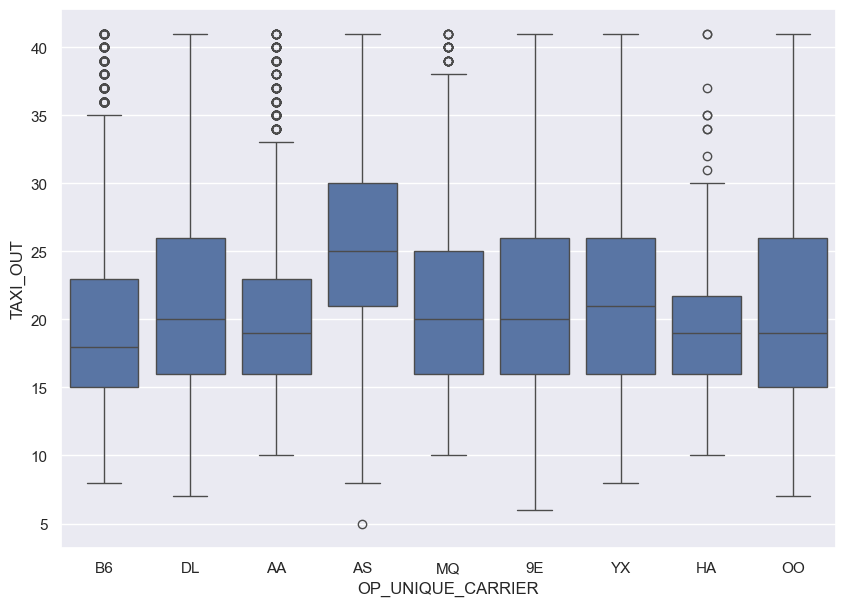

In [9]:
sns.set(rc={'figure.figsize':(10,7)})
sns.boxplot(y = df.TAXI_OUT, x = df.OP_UNIQUE_CARRIER)

In [4]:
df['Dew Point'] = df['Dew Point'].astype(int)

In [5]:
categorical_features = list(df.select_dtypes('object').columns)
numerical_features = list(df.select_dtypes(exclude = ['object']).columns)

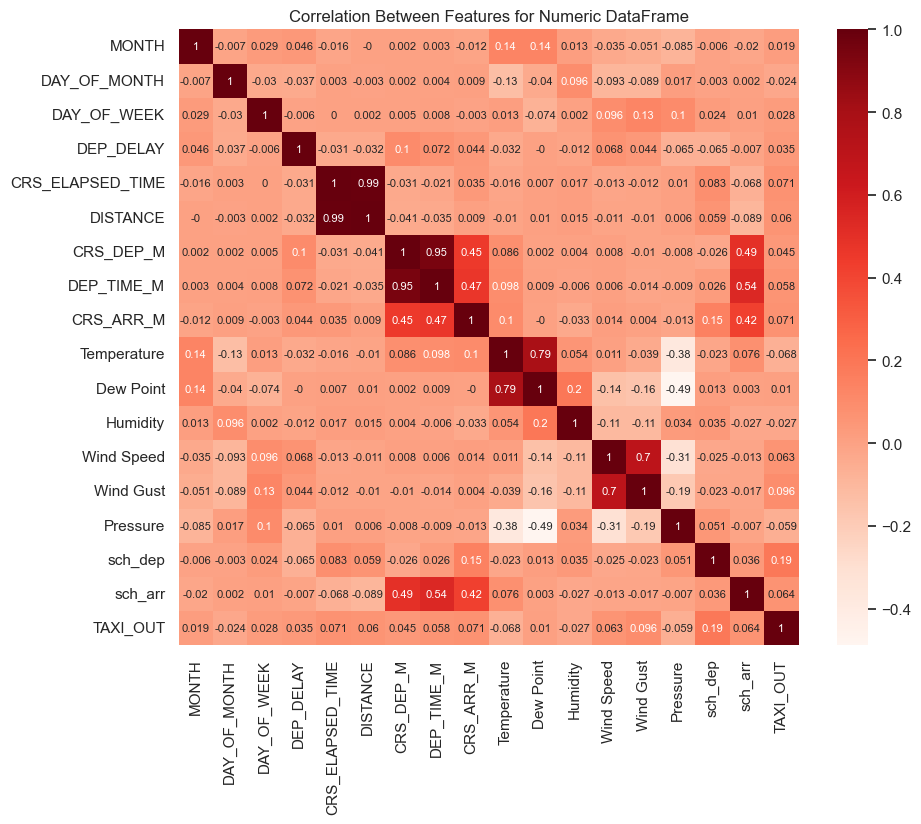

In [6]:
#df
plt.figure(figsize = (10,8))
feature_dfcorrelation = df[numerical_features].corr().round(3)
heatmap = sns.heatmap(feature_dfcorrelation, annot = True, cmap = plt.cm.Reds, annot_kws = {'size':8})
heatmap.set_title('Correlation Between Features for Numeric DataFrame')
plt.show()

We see that we have two entries have NaN in the wind column.

Extract object column names from the dataframe.\
There were originally 2 Nan values in the 'Wind' feature that were filled withc 'NW', and column was renamed 'Wind_fillna'.\
The 'Dew Point' column was converted to an integer data type, so it is no longer included as an object column.

The 'Dew Point' feature is a string of integers instead of numerical data.\
Use astype(int) to convert data to integers without loss of data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              28820 non-null  int64  
 1   DAY_OF_MONTH       28820 non-null  int64  
 2   DAY_OF_WEEK        28820 non-null  int64  
 3   OP_UNIQUE_CARRIER  28820 non-null  object 
 4   TAIL_NUM           28820 non-null  object 
 5   DEST               28820 non-null  object 
 6   DEP_DELAY          28820 non-null  int64  
 7   CRS_ELAPSED_TIME   28820 non-null  int64  
 8   DISTANCE           28820 non-null  int64  
 9   CRS_DEP_M          28820 non-null  int64  
 10  DEP_TIME_M         28820 non-null  int64  
 11  CRS_ARR_M          28820 non-null  int64  
 12  Temperature        28820 non-null  int64  
 13  Dew Point          28820 non-null  int64  
 14  Humidity           28820 non-null  int64  
 15  Wind               28818 non-null  object 
 16  Wind Speed         288

In [8]:
df.isna().sum()

MONTH                0
DAY_OF_MONTH         0
DAY_OF_WEEK          0
OP_UNIQUE_CARRIER    0
TAIL_NUM             0
DEST                 0
DEP_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE             0
CRS_DEP_M            0
DEP_TIME_M           0
CRS_ARR_M            0
Temperature          0
Dew Point            0
Humidity             0
Wind                 2
Wind Speed           0
Wind Gust            0
Pressure             0
Condition            0
sch_dep              0
sch_arr              0
TAXI_OUT             0
dtype: int64

In [9]:
df = df.dropna()

In [10]:
X = df.drop('TAXI_OUT', axis=1)
y = df.TAXI_OUT

In [11]:
X['OP_UNIQUE_CARRIER'] = X['OP_UNIQUE_CARRIER'].map({'B6':0,'AA':1,'Other':2,'AS':3})
X['OP_UNIQUE_CARRIER'] = df.groupby('OP_UNIQUE_CARRIER')['TAXI_OUT'].transform('mean')

In [12]:
X['Condition'] = df['Condition'].replace(['Fair / Windy', 'Fair', 'Light Rain / Windy', 
                                                               'Partly Cloudy', 'Mostly Cloudy', 'Cloudy', 'Light Rain', 
                                                               'Mostly Cloudy / Windy', 'Partly Cloudy / Windy', 
                                                               'Light Snow / Windy', 'Cloudy / Windy', 'Light Drizzle', 
                                                               'Rain', 'Heavy Rain', 'Fog', 'Wintry Mix', 
                                                               'Rain / Windy'], 0)
X['Condition'] = df['Condition'].map({'Heavy Rain / Windy':1, 'Fog / Windy':2, 'Drizzle and Fog':3, 
                                                           'Light Snow':4, 'Light Drizzle / Windy':5, 
                                                           'Light Freezing Rain':6, 'Snow':7, 'Wintry Mix / Windy':8})

X['Condition'] = df.groupby('Condition')['TAXI_OUT'].transform('mean')

In [13]:
X['Wind'] = X['Wind'].replace(['CALM','VAR'], 0)
X['Wind'] = X['Wind'].replace(['W', 'S', 'E', 'N'], 1)
X['Wind'] = X['Wind'].replace(['NW', 'NE', 'SE','SW'], 2)
X['Wind'] = X['Wind'].replace(['WNW', 'NNW', 'ENE', 'NNE', 'SSE', 'SSW', 'WSW', 'ESE'], 3)

X['Wind'] = df.groupby('Wind')['TAXI_OUT'].transform('mean')

In [14]:
X['TAIL_NUM'] = df.groupby('TAIL_NUM')['TAXI_OUT'].transform('mean')

In [15]:
X['DEST'] = df.groupby('DEST')['TAXI_OUT'].transform('mean')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [17]:
X_test

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,DEST,DEP_DELAY,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,...,Temperature,Dew Point,Humidity,Wind,Wind Speed,Wind Gust,Pressure,Condition,sch_dep,sch_arr
3668,11,12,2,21.615755,19.857143,22.329268,-4,187,1029,669,...,39,31,73,21.070280,15,0,29.87,20.258814,29,20
11512,12,7,6,19.557363,20.525000,20.734908,-4,105,427,1030,...,35,16,46,21.070280,12,0,30.43,20.240969,23,30
24387,1,17,5,19.557363,19.928571,20.817121,95,83,264,1370,...,38,37,97,19.641605,17,0,29.77,20.258814,14,12
1872,11,6,3,19.557363,18.784314,19.992470,9,179,1005,1305,...,49,35,59,19.641605,9,0,30.37,20.240969,30,28
6666,11,21,4,21.180196,20.285714,20.606299,-10,265,1391,510,...,44,33,65,20.678761,8,0,30.21,20.240969,51,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,11,13,3,21.615755,22.647059,21.563506,-4,328,1990,420,...,25,10,53,21.070280,21,30,30.30,21.265795,15,17
4422,11,14,4,20.554103,18.000000,22.121453,-3,197,1089,930,...,45,27,49,20.214528,10,0,30.33,20.469086,30,37
16539,12,24,2,19.557363,21.722222,19.590778,20,148,718,424,...,41,31,67,21.268750,10,0,30.09,20.469086,31,29
15699,12,21,6,21.615755,24.375000,19.422951,-4,207,1074,926,...,35,27,72,20.547794,3,0,30.50,20.258814,35,38


In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25936 entries, 27727 to 2732
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MONTH              25936 non-null  int64  
 1   DAY_OF_MONTH       25936 non-null  int64  
 2   DAY_OF_WEEK        25936 non-null  int64  
 3   OP_UNIQUE_CARRIER  25936 non-null  float64
 4   TAIL_NUM           25936 non-null  float64
 5   DEST               25936 non-null  float64
 6   DEP_DELAY          25936 non-null  int64  
 7   CRS_ELAPSED_TIME   25936 non-null  int64  
 8   DISTANCE           25936 non-null  int64  
 9   CRS_DEP_M          25936 non-null  int64  
 10  DEP_TIME_M         25936 non-null  int64  
 11  CRS_ARR_M          25936 non-null  int64  
 12  Temperature        25936 non-null  int64  
 13  Dew Point          25936 non-null  int64  
 14  Humidity           25936 non-null  int64  
 15  Wind               25936 non-null  float64
 16  Wind Speed         25936

In [19]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
fullModel = sm.OLS(y_train, X_train).fit()

fullModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     288.2
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:09:37   Log-Likelihood:                -83888.
No. Observations:               25936   AIC:                         1.678e+05
Df Residuals:                   25913   BIC:                         1.680e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -9.2818      5.364     -1.730      0.084     -19.795       1.232
MONTH                 0.0322      0.008      4.089      0.000       0.017       0.048
DAY_OF_MONTH         -0.0216      0.004     -4.820      0.000      -0.030      -0.013
DAY_OF_WEEK           0.1103      0.020      5.566      0.000       0.071       0.149
OP_UNIQUE_CARRIER    -0.0794      0.038     -2.074      0.038      -0.154      -0.004
TAIL_NUM              0.8880      0.020     43.393      0.000       0.848       0.928
DEST                  0.6209      0.036     17.376      0.000       0.551       0.691
DEP_DELAY             0.0051      0.001      4.986      0.000       0.003       0.007
CRS_ELAPSED_TIME      0.0002      0.003      0.055      0.956      -0.007       0.007
DISTANCE             -0.0001      0.000     -0.324      0.746      -0.001       0.001
CRS_DEP_M             0.0004      0.000      1.129      0.259      -0.000       0.001
DEP_TIME_M            0.0007      0.000      1.809      0.070   -6.04e-05       0.002
CRS_ARR_M            -0.0002      0.000     -1.417      0.156      -0.000    7.35e-05
Temperature          -0.1531      0.009    -17.418      0.000      -0.170      -0.136
Dew Point             0.0661      0.007     10.076      0.000       0.053       0.079
Humidity             -0.0015      0.002     -0.827      0.408      -0.005       0.002
Wind                  0.5320      0.053     10.126      0.000       0.429       0.635
Wind Speed           -0.0099      0.009     -1.063      0.288      -0.028       0.008
Wind Gust             0.0339      0.005      7.297      0.000       0.025       0.043
Pressure             -0.8433      0.170     -4.947      0.000      -1.177      -0.509
Condition             0.6417      0.037     17.535      0.000       0.570       0.713
sch_dep               0.1046      0.004     24.574      0.000       0.096       0.113
sch_arr               0.0463      0.006      8.034      0.000       0.035       0.058
==============================================================================
Omnibus:                     1559.480   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1853.531
Skew:                           0.639   Prob(JB):                         0.00
Kurtosis:                       3.287   Cond. No.                     2.93e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
X_train = X_train.drop(['Wind Speed'], axis=1)
X_test = X_test.drop(['Wind Speed'], axis=1)

In [21]:
fullModel = sm.OLS(y_train, X_train).fit()

fullModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     301.9
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:09:37   Log-Likelihood:                -83888.
No. Observations:               25936   AIC:                         1.678e+05
Df Residuals:                   25914   BIC:                         1.680e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -11.1242      5.076     -2.191      0.028     -21.074      -1.175
MONTH                 0.0324      0.008      4.116      0.000       0.017       0.048
DAY_OF_MONTH         -0.0215      0.004     -4.792      0.000      -0.030      -0.013
DAY_OF_WEEK           0.1094      0.020      5.526      0.000       0.071       0.148
OP_UNIQUE_CARRIER    -0.0791      0.038     -2.066      0.039      -0.154      -0.004
TAIL_NUM              0.8880      0.020     43.389      0.000       0.848       0.928
DEST                  0.6210      0.036     17.378      0.000       0.551       0.691
DEP_DELAY             0.0051      0.001      4.942      0.000       0.003       0.007
CRS_ELAPSED_TIME      0.0002      0.003      0.045      0.964      -0.007       0.007
DISTANCE             -0.0001      0.000     -0.314      0.754      -0.001       0.001
CRS_DEP_M             0.0005      0.000      1.140      0.254      -0.000       0.001
DEP_TIME_M            0.0007      0.000      1.794      0.073   -6.63e-05       0.002
CRS_ARR_M            -0.0002      0.000     -1.398      0.162      -0.000    7.61e-05
Temperature          -0.1548      0.009    -17.927      0.000      -0.172      -0.138
Dew Point             0.0680      0.006     10.794      0.000       0.056       0.080
Humidity             -0.0016      0.002     -0.888      0.374      -0.005       0.002
Wind                  0.5338      0.053     10.164      0.000       0.431       0.637
Wind Gust             0.0309      0.004      8.294      0.000       0.024       0.038
Pressure             -0.7833      0.161     -4.870      0.000      -1.099      -0.468
Condition             0.6372      0.036     17.529      0.000       0.566       0.708
sch_dep               0.1045      0.004     24.557      0.000       0.096       0.113
sch_arr               0.0465      0.006      8.072      0.000       0.035       0.058
==============================================================================
Omnibus:                     1555.339   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1847.742
Skew:                           0.638   Prob(JB):                         0.00
Kurtosis:                       3.285   Cond. No.                     2.78e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
X_train = X_train.drop(columns=['Humidity'])
X_test = X_test.drop(columns=['Humidity'])

In [23]:
fullModel = sm.OLS(y_train, X_train).fit()

fullModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     316.9
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:09:37   Log-Likelihood:                -83889.
No. Observations:               25936   AIC:                         1.678e+05
Df Residuals:                   25915   BIC:                         1.680e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -10.8926      5.069     -2.149      0.032     -20.829      -0.956
MONTH                 0.0323      0.008      4.109      0.000       0.017       0.048
DAY_OF_MONTH         -0.0218      0.004     -4.864      0.000      -0.031      -0.013
DAY_OF_WEEK           0.1090      0.020      5.507      0.000       0.070       0.148
OP_UNIQUE_CARRIER    -0.0789      0.038     -2.060      0.039      -0.154      -0.004
TAIL_NUM              0.8879      0.020     43.388      0.000       0.848       0.928
DEST                  0.6209      0.036     17.377      0.000       0.551       0.691
DEP_DELAY             0.0051      0.001      4.955      0.000       0.003       0.007
CRS_ELAPSED_TIME      0.0001      0.003      0.043      0.966      -0.007       0.007
DISTANCE             -0.0001      0.000     -0.312      0.755      -0.001       0.001
CRS_DEP_M             0.0004      0.000      1.101      0.271      -0.000       0.001
DEP_TIME_M            0.0007      0.000      1.822      0.069   -5.53e-05       0.002
CRS_ARR_M            -0.0002      0.000     -1.390      0.165      -0.000    7.72e-05
Temperature          -0.1533      0.008    -18.127      0.000      -0.170      -0.137
Dew Point             0.0663      0.006     11.078      0.000       0.055       0.078
Wind                  0.5369      0.052     10.248      0.000       0.434       0.640
Wind Gust             0.0307      0.004      8.248      0.000       0.023       0.038
Pressure             -0.8015      0.160     -5.024      0.000      -1.114      -0.489
Condition             0.6447      0.035     18.243      0.000       0.575       0.714
sch_dep               0.1044      0.004     24.545      0.000       0.096       0.113
sch_arr               0.0465      0.006      8.081      0.000       0.035       0.058
==============================================================================
Omnibus:                     1554.966   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1847.237
Skew:                           0.638   Prob(JB):                         0.00
Kurtosis:                       3.285   Cond. No.                     2.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [25]:
X_test.columns

Index(['const', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER',
       'TAIL_NUM', 'DEST', 'DEP_DELAY', 'CRS_ELAPSED_TIME', 'DISTANCE',
       'CRS_DEP_M', 'DEP_TIME_M', 'CRS_ARR_M', 'Temperature', 'Dew Point',
       'Wind', 'Wind Gust', 'Pressure', 'Condition', 'sch_dep', 'sch_arr'],
      dtype='object')

In [26]:
heatmapX = X_train[['const', 'TAIL_NUM', 'sch_dep', 'OP_UNIQUE_CARRIER', 'Condition', 'DEST', 'Wind']]
heatmapX

,const,TAIL_NUM,sch_dep,OP_UNIQUE_CARRIER,Condition,DEST,Wind
27727,1.0,24.235294,35,25.536454,20.970674,23.405045,21.070280
12784,1.0,20.714286,21,21.615755,20.240969,20.218825,20.218677
12960,1.0,23.325581,30,21.615755,20.628856,23.405045,19.742029
8645,1.0,18.800000,51,21.615755,20.258814,19.995776,23.173488
8915,1.0,18.724138,22,19.557363,20.628856,21.188299,19.641605
...,...,...,...,...,...,...,...
13123,1.0,20.400000,19,21.615755,20.258814,22.329268,21.268750
19650,1.0,23.281250,54,21.180196,22.221448,20.606299,20.547794
9845,1.0,22.705882,53,21.615755,20.258814,26.661290,23.173488
10799,1.0,21.285714,32,21.180196,20.469086,22.891089,20.774519


In [27]:
heatmapModel = sm.OLS(y_train, heatmapX).fit()
heatmapModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     917.1
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:09:37   Log-Likelihood:                -84230.
No. Observations:               25936   AIC:                         1.685e+05
Df Residuals:                   25929   BIC:                         1.685e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -41.5625      1.450    -28.661      0.000     -44.405     -38.720
TAIL_NUM              0.9080      0.021     43.897      0.000       0.867       0.949
sch_dep               0.1073      0.004     25.993      0.000       0.099       0.115
OP_UNIQUE_CARRIER    -0.1488      0.037     -4.004      0.000      -0.222      -0.076
Condition             0.8652      0.033     26.620      0.000       0.802       0.929
DEST                  0.5725      0.034     16.804      0.000       0.506       0.639
Wind                  0.6368      0.052     12.312      0.000       0.535       0.738
==============================================================================
Omnibus:                     1709.947   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2065.620
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       3.318   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
backwardX = X_train[['const', 'TAIL_NUM', 'sch_dep', 'OP_UNIQUE_CARRIER', 'Condition', 'DEST', 'Wind']]
backwardXModel = sm.OLS(y_train, backwardX).fit()
backwardXModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TAXI_OUT   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     917.1
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        15:09:37   Log-Likelihood:                -84230.
No. Observations:               25936   AIC:                         1.685e+05
Df Residuals:                   25929   BIC:                         1.685e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -41.5625      1.450    -28.661      0.000     -44.405     -38.720
TAIL_NUM              0.9080      0.021     43.897      0.000       0.867       0.949
sch_dep               0.1073      0.004     25.993      0.000       0.099       0.115
OP_UNIQUE_CARRIER    -0.1488      0.037     -4.004      0.000      -0.222      -0.076
Condition             0.8652      0.033     26.620      0.000       0.802       0.929
DEST                  0.5725      0.034     16.804      0.000       0.506       0.639
Wind                  0.6368      0.052     12.312      0.000       0.535       0.738
==============================================================================
Omnibus:                     1709.947   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2065.620
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       3.318   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

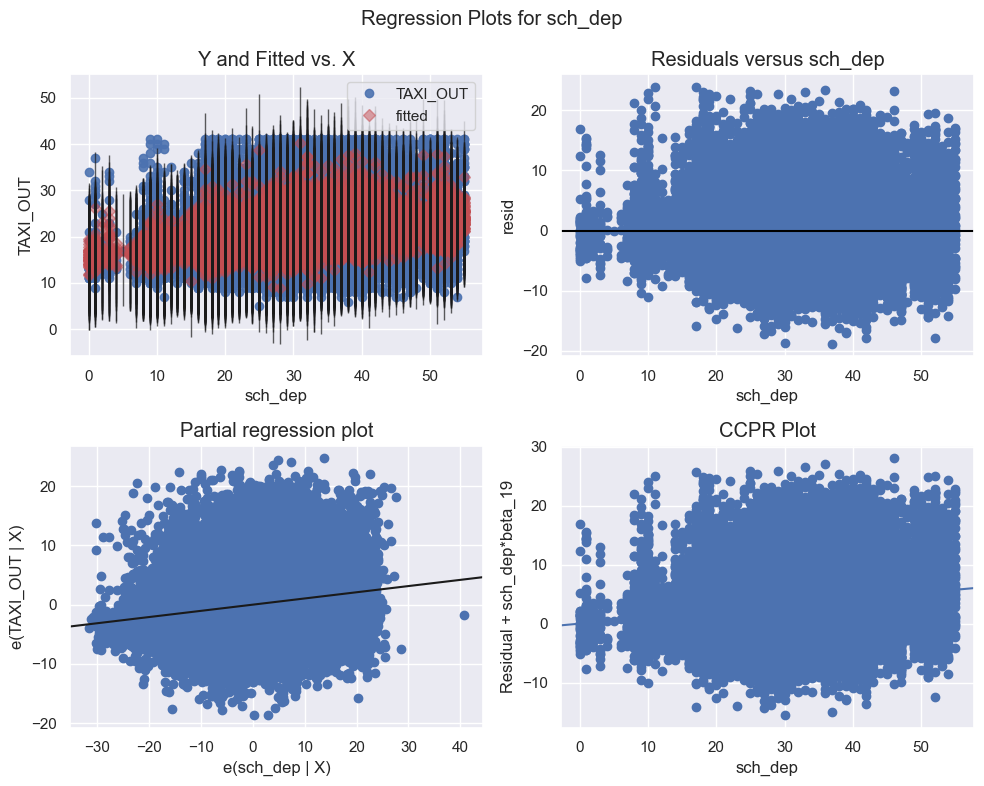

In [29]:
fig = plt.figure(figsize=(10, 8))
fig = sm.graphics.plot_regress_exog(fullModel, 'sch_dep', fig=fig)

In [ ]:
plt.scatter(

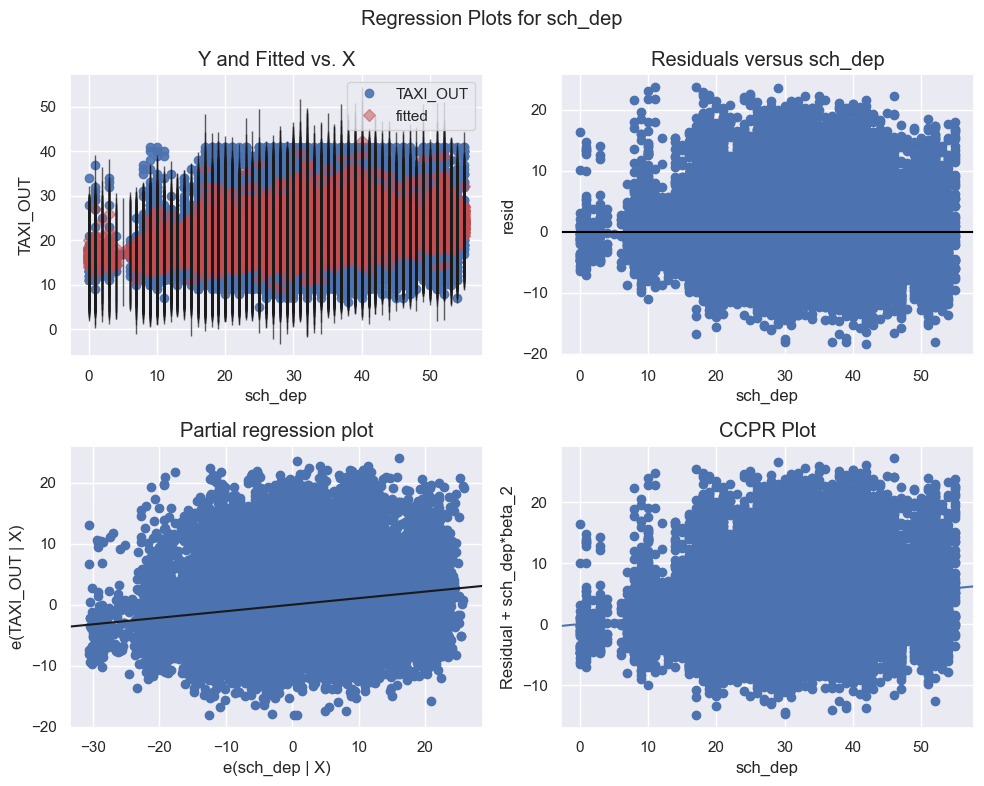

In [30]:
figBackward = plt.figure(figsize=(10, 8))
figBackward = sm.graphics.plot_regress_exog(backwardXModel, 'sch_dep', fig=figBackward)